In [1]:
#!pip install tensorflow==2.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 83.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 87.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 52.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled 

In [2]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import itertools
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

2023-10-22 14:41:02.150042: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
#parameters
classes = 2
IMAGE_SIZE = [512,512]
TH = 512
H, W = 512, 512
C = 3
num_class = 3
batch_size = 32
class_names = ["breast_benign", "breast_malignant"]
LR = 1e-5
epcochs = 40

# Function

In [4]:
#read the data
def load_data(path, split=0.2):
    images = shuffle(sorted(glob(os.path.join(path, "*", "*"))))
    split_rate = int(len(images) * split)
    train, valid = train_test_split(images, test_size=split_rate, random_state=42)
    train, test = train_test_split(train, test_size=split_rate, random_state=42)
    return train, valid, test

In [5]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def PlotImg(img_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, IMAGE_SIZE)
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [8]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, 2)
    image.set_shape([H, W, C])
    labels.set_shape(2)
  
    return image, labels

In [9]:
#tensorflow dataset
def tf_dataset(images, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(8)
    return dataset

In [10]:
#callbacks parameter //paths
model_path = "resnet_for_breast_cancer-v1.h5"
csv_path = "brain_tumor_2.csv"

In [11]:
path = "/kaggle/input/multi-cancer/Multi Cancer/Breast Cancer/"

# Data Pipeline

In [12]:
train, valid, test = load_data(path)

In [13]:
print(f"Train:{len(train)} - Valid: {len(valid)} - Test:{len(test)}")

Train:6000 - Valid: 2000 - Test:2000


In [14]:
#tensor dataset
train_df = tf_dataset(train)
valid_df = tf_dataset(valid)
test_df = tf_dataset(test)

In [15]:
for i,j in train_df.take(1):
    print(i.numpy().shape)

(32, 512, 512, 3)


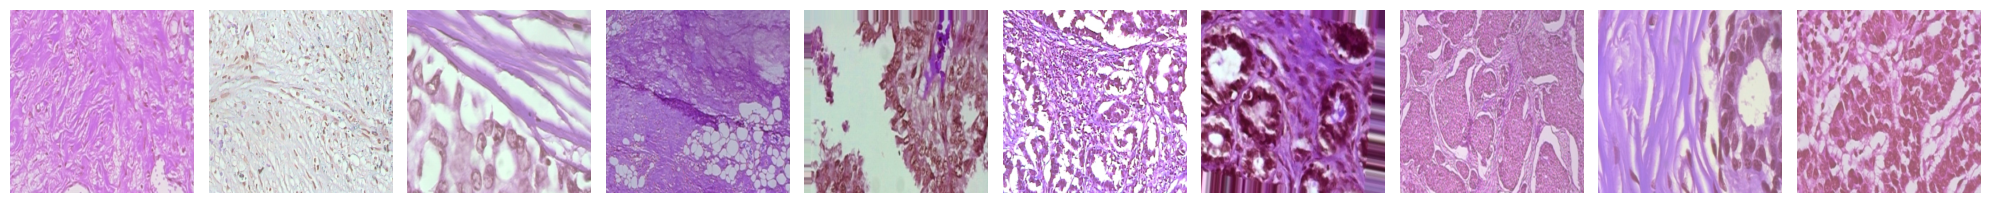

In [16]:
imgs, labels = next(iter(train_df))
PlotImg(imgs)

# Model

In [53]:
resnet = ResNet50(input_shape=IMAGE_SIZE+[3], include_top=False, weights='imagenet')

In [54]:
for layer in resnet.layers:
    layer.trainable = False

In [55]:
#build our layers
x = layers.Flatten()(resnet.output)

In [56]:
#set last layer
prediction_layer = layers.Dense(len(class_names), activation='sigmoid' )(x)
#declare the model
model = Model(inputs=resnet.input, outputs=prediction_layer)

In [58]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-8, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
]

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss='binary_crossentropy', metrics=['accuracy'])

# Training

In [61]:
r = model.fit(x=train_df, validation_data=valid_df, epochs=50, callbacks=callbacks)

Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.7048
Epoch 1: val_loss improved from inf to 0.49204, saving model to resnet_for_breast_cancer-v1.h5
188/188 [==============================] - 87s 448ms/step - loss: 0.5872 - accuracy: 0.7048 - val_loss: 0.4920 - val_accuracy: 0.7845 - lr: 2.0000e-05
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.7647
Epoch 2: val_loss improved from 0.49204 to 0.42796, saving model to resnet_for_breast_cancer-v1.h5
188/188 [==============================] - 85s 451ms/step - loss: 0.4989 - accuracy: 0.7647 - val_loss: 0.4280 - val_accuracy: 0.8180 - lr: 2.0000e-05
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.7982
Epoch 3: val_loss improved from 0.42796 to 0.39049, saving model to resnet_for_breast_cancer-v1.h5
188/188 [==============================] - 83s 442ms/step - loss: 0.4466 - accuracy: 0.7982 - val_loss: 0.3905 - val_

# Evaluation of model

In [62]:
#plot confusion matrix
def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=45)
    plt.yticks(tick_mark, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.axis]
        print("normalized confusion matrix")

    else:
        print("confusion matrix without normalization")

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.xlabel("predicted label")
        plt.ylabel("True label")

In [63]:
saved_model = load_model('/kaggle/working/resnet_for_breast_cancer-v1.h5')

In [64]:
#prediction
prediction = saved_model.predict(test_df, verbose=0)

In [65]:
#scale the predicted value
np.around(prediction)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [66]:
#get the max value 
y_pred_classes = np.argmax(prediction, axis=1)

In [67]:
#function for get labels of test set
def get_test_data_class(test_path):
    names = []
    for i in test_path:
        name = i.split("/")[-2]
        name_idx = class_names.index(name)
        names.append(name_idx)
    names = np.array(names, dtype=np.int32)
    return names

In [68]:
classes = get_test_data_class(test)

confusion matrix without normalization


/tmp/ipykernel_32/3594088673.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


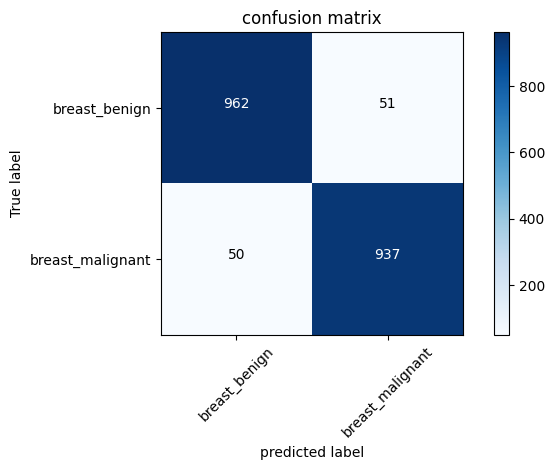

In [69]:
#confusion matrix
cm = confusion_matrix(y_true=classes, y_pred=y_pred_classes)
plt_confusion_matrix(cm=cm, classes=class_names, title="confusion matrix", )

In [70]:
from sklearn.metrics import classification_report
print(classification_report(classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1013
           1       0.95      0.95      0.95       987

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

